# Import

In [73]:
import torch
import matplotlib.pyplot as plt
from statistics import mean
from tqdm import tqdm
import pandas as pd
from torch_geometric.data import Data
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle
%matplotlib inline

In [74]:
from graph_generation_trade import dict_snapshots_trade, temporal_data_trade

snapshots_trade = list(dict_snapshots_trade.values())

from models_and_utils import (
    data_split, train_snapshots, test_snapshots, apply_negative_sampling
)

# Functions

In [75]:
def train_snapshots(model, graph_snapshots_train, optimiser, epochs):

    model.train(True)
    loss_epochs_dict = {}

    for epoch in tqdm(range(epochs)):
        
        losses_list = []
        non_zero_gradients = 0

        for snapshot in graph_snapshots_train:
            optimiser.zero_grad()

            edge_weights_pred = model(snapshot)

            loss = torch.mean((edge_weights_pred - snapshot.edge_weights)**2)
            loss.backward()
            
            for param in model.parameters():
                if param.grad is not None:
                    if torch.sum(param.grad) != 0:
                        non_zero_gradients += 1
            
            optimiser.step()
            losses_list.append(loss.item())

        if non_zero_gradients == 0:
            print("Warning: No non-zero gradients found in epoch {}".format(epoch))

        if epoch % 10 == 0:
            plt.scatter(edge_weights_pred.detach().numpy(), snapshot.edge_weights.detach().numpy())
            plt.xlabel('pred')
            plt.ylabel('true')
            plt.xlim(left=0)
            plt.show()

        avg_epoch_loss = mean(losses_list)
        loss_epochs_dict[epoch+1] = avg_epoch_loss 

    loss_epochs_df = pd.DataFrame(loss_epochs_dict.items(), columns=['epoch', 'loss'])
    return loss_epochs_df

def test_snapshots(model, graph_snapshots_test):
    with torch.no_grad():
        model.eval()
        loss = 0
        for snapshot in graph_snapshots_test:
            edge_weights_pred = model(snapshot)
            mse = torch.mean((edge_weights_pred - snapshot.edge_weights)**2)
            loss += mse
        loss = loss / (len(graph_snapshots_test))
        print(f'MSE = {loss.item():.4f}')

In [76]:
def GATR_train(model, graph_snapshots_train, window, optimiser, epochs):
    model.train()
    loss_epochs_df = pd.DataFrame(columns=['epoch', 'loss'])

    for epoch in tqdm(range(epochs)):
        
        losses_list = []
        non_zero_gradients = 0

        for i in range(window+1, len(graph_snapshots_train)):
            s = graph_snapshots_train[i]
            s_lag1 = graph_snapshots_train[i-1]
            s_lag2 = graph_snapshots_train[i-2]
            s_lag3 = graph_snapshots_train[i-3]
            s_lag4 = graph_snapshots_train[i-4]
            lagged_snapshots = [s_lag4, s_lag3, s_lag2, s_lag1]
            
            optimiser.zero_grad()
            
            edge_weights_pred = model(lagged_snapshots)
            loss = torch.mean((edge_weights_pred - s.edge_weights)**2)
            loss.backward()

            for param in model.parameters():
                if param.grad is not None:
                    if torch.sum(param.grad) != 0:
                        non_zero_gradients += 1
        
            optimiser.step()
            losses_list.append(loss.item())
    
        if non_zero_gradients == 0:
            print("Warning: No non-zero gradients found in epoch {}".format(epoch))

        if epoch % 10 == 0:
            plt.scatter(edge_weights_pred.detach().numpy(), s.edge_weights.detach().numpy())
            plt.xlabel('pred')
            plt.ylabel('true')
            plt.xlim(left=0)
            plt.show()

        avg_epoch_loss = mean(losses_list)
        loss_epochs_df.loc[len(loss_epochs_df)]={'epoch':epoch+1, 'loss':avg_epoch_loss}

    return loss_epochs_df

# Data

In [77]:
# ## ORIGINAL ###
## Snapshots    
# data = snapshots_trade
# data_train, data_test = data_split(graph_snapshots=data, split_ratio=0.9)

## Temporal (for TGN)
# tmp_data_trade, node_features, edge_weights = temporal_data_trade 

## Dummy tests

### Level 1

Dummy data description: give the same graph with equal node features and equal edge weights set to 10. 

Result: ModelMPNN: ✅  |   ModelEVOLVE: ✅   |   ModelA3TGCN: ✅   |   ModelGATR: ✅  |  ModelTGN: ❌

In [78]:
# x = torch.ones((14,1)) 
# edge_index = torch.tensor([[ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  9,  9,  9,  9,  9,  9, 9,  9,  9,  9,  9,  9],
#                            [ 0,  1,  2,  3,  4,  5,  7,  8, 10, 11, 12, 13,  0,  1,  2,  3,  4,  5, 7,  8, 10, 11, 12, 13]])
# edge_weights = torch.full((24,1), 10)
# edge_weights_index = edge_index.detach().clone()
# num_nodes = 14
# dummy_data = Data(x=x, edge_index=edge_index, edge_weights=edge_weights, edge_weights_index=edge_weights_index, num_nodes=num_nodes)
# data_train = [dummy_data for i in range(10)]

In [79]:
# tmp_data_trade, node_features, edge_weights = temporal_data_trade 
# node_features = {i:torch.zeros(node_features[0].size()) for i in range(max(node_features.keys())+1)}
# edge_weights = torch.full_like(edge_weights, 10)

### Level 2

Level description: give the same graph many times with different node features and equal edge weights set to 10.

Result: ModelMPNN: ✅  |   ModelEVOLVE: ✅   |   ModelA3TGCN: ✅   |   ModelGATR: ✅  |  ModelTGN: ❌

In [82]:
# x = torch.randint(1,5, (14,1), dtype=torch.float)
# edge_index = torch.tensor([[ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  9,  9,  9,  9,  9,  9, 9,  9,  9,  9,  9,  9],
#                            [ 0,  1,  2,  3,  4,  5,  7,  8, 10, 11, 12, 13,  0,  1,  2,  3,  4,  5, 7,  8, 10, 11, 12, 13]])
# edge_weights = torch.full((24,1), 10)
# edge_weights_index = edge_index.detach().clone()
# num_nodes = 14
# dummy_data = Data(x=x, edge_index=edge_index, edge_weights=edge_weights, edge_weights_index=edge_weights_index, num_nodes=num_nodes)
# data_train = [dummy_data for i in range(10)]

### Level 3

Level description: give multiple graphs with same structure but different node features and equal edge weights set to 5.

Result: ModelMPNN: ✅  |   ModelEVOLVE: ✅   |   ModelA3TGCN: ✅   |   ModelGATR: ✅  |  ModelTGN: ❌

In [91]:
edge_index = torch.tensor([[ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  9,  9,  9,  9,  9,  9, 9,  9,  9,  9,  9,  9],
                           [ 0,  1,  2,  3,  4,  5,  7,  8, 10, 11, 12, 13,  0,  1,  2,  3,  4,  5, 7,  8, 10, 11, 12, 13]])
edge_weights = torch.full((24,1), 5)
edge_weights_index = edge_index.detach().clone()
num_nodes = 14

data_train = []
for i in range(100):
    x = torch.randint(1,10, (14,1), dtype=torch.float)
    dummy_graph_i = Data(x=x, edge_index=edge_index, edge_weights=edge_weights, edge_weights_index=edge_weights_index, num_nodes=num_nodes)
    data_train.append(dummy_graph_i)

### Level 4

Level description: give multiple graphs with same structure with fixed node features and edge features equal to the ID of the source node. 

### Dummy level 6

Dummy experiment description: predict the value of the weights of all edges where the sum of all exports = production.

Result: ModelMPNN:   |   ModelEVOLVE:    |   ModelA3TGCN:    |   ModelGATR:   |  ModelTGN: ❌

In [65]:
# with open('trade_data_dummy_level2.pkl', 'rb') as f:
#     snapshots_trade_dummy2 = pickle.load(f)

# snapshots_trade_dummy2 = list(snapshots_trade_dummy2.values())

# # Snapshots    
# data = snapshots_trade_dummy2
# data_train, data_test = data_split(graph_snapshots=data, split_ratio=0.9)

# Snapshot-based models

In [ ]:
from models_and_utils import ModelMPNN

in_channels = data_train[0].x.shape[1]
hidden_size = 16
num_nodes = data_train[0].x.shape[0]
window = 1
dropout_p = 0.1
model1 = ModelMPNN(in_channels, hidden_size, num_nodes, window, dropout_p)

lr = 0.5
optimiser = torch.optim.Adam(model1.parameters(), lr=lr)
epochs = 50

results = train_snapshots(model1, data_train, optimiser, epochs)
results['loss'].plot()
plt.show()

# results = test_snapshots(model1, data_test)

In [ ]:
from models_and_utils import ModelEVOLVE

in_channels = hidden_size = data_train[0].x.shape[1]
num_nodes = data_train[0].x.shape[0]
window = 1
dropout_p = 0.0

model2 = ModelEVOLVE(num_nodes, hidden_size, in_channels, dropout_p)

lr = 0.5
epochs = 50
optimiser = torch.optim.Adam(model2.parameters(), lr=lr)

results = train_snapshots(model2, data_train, optimiser, epochs)
results['loss'].plot()
plt.show()

# results = test_snapshots(model2, data_test)

In [ ]:
from models_and_utils import ModelA3TGCN

in_channels = data_train[0].x.shape[1]
hidden_size = 16
dropout_p = 0.1
periods = 1

model3 = ModelA3TGCN(in_channels, hidden_size, dropout_p, periods)

lr = 0.5
epochs = 50
optimiser = torch.optim.Adam(model3.parameters(), lr=lr)

train_snapshots(model3, data_train, optimiser, epochs)['loss'].plot()
plt.show()

#test_snapshots(model3, data_test)

In [95]:
from models_and_utils import ModelGATR

in_channels = data_train[0].x.shape[1]
hidden_size = 16
num_heads_GAT = 2
dropout_p_GAT = 0.1
edge_dim_GAT = 0
momentum_GAT = 0.1

num_heads_TR = 2
num_encoder_layers_TR = 2
num_decoder_layers_TR = 2
dropout_p_TR = 0.1

model4 = ModelGATR(in_channels=in_channels, hidden_size=hidden_size, 
                   num_heads_GAT=num_heads_GAT, dropout_p_GAT=dropout_p_GAT, 
                   edge_dim_GAT=edge_dim_GAT, momentum_GAT=momentum_GAT, 
                   num_heads_TR=num_heads_TR, num_encoder_layers_TR=num_encoder_layers_TR, 
                   num_decoder_layers_TR=num_decoder_layers_TR, 
                   dropout_p_TR=dropout_p_TR)

In [ ]:
lr = 0.5
epochs = 50
optimiser = torch.optim.Adam(model4.parameters(), lr=lr)

GATR_train(model=model4, graph_snapshots_train=data_train, window=4, optimiser=optimiser, epochs=epochs)['loss'].plot()

# TGN

In [32]:
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)
from models_and_utils import TGNEncoder, TGNDecoder, TGN_train

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tmp_data_trade, node_features, edge_weights = temporal_data_trade 
data_train, val_data, data_test = tmp_data_trade.train_val_test_split(
    val_ratio=0, test_ratio=0.10)

train_loader = TemporalDataLoader(
    data_train,
    batch_size=200,
    neg_sampling_ratio=1.0,
)

test_loader = TemporalDataLoader(
    data_test,
    batch_size=200,
    neg_sampling_ratio=1.0,
)

msg_size = tmp_data_trade.msg.size(-1)
num_nodes = tmp_data_trade.num_nodes

in_channels = 16
out_channels = 16
time_dim = 16
node_features_dim = node_features[0].size(-1)

identity_message = IdentityMessage(msg_size, in_channels, time_dim)
neighbor_loader = LastNeighborLoader(tmp_data_trade.num_nodes, size=50, device=device)
memory = TGNMemory(num_nodes, msg_size, in_channels, time_dim, 
                   message_module=identity_message,
                   aggregator_module=LastAggregator())

model5_enc = TGNEncoder(in_channels=in_channels, out_channels=out_channels,
                        msg_dim=msg_size, time_enc=memory.time_enc, 
                        node_features_dim=node_features_dim).to(device)

model5_dec = TGNDecoder(hidden_size=out_channels)
assoc = torch.empty(num_nodes, dtype=torch.long, device=device)

100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


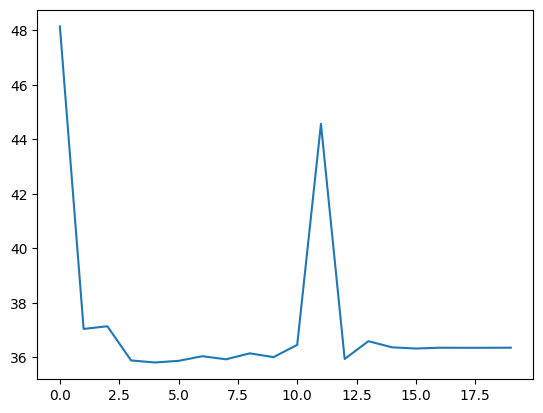

In [33]:
epochs = 20
lr = 0.1

optimiser = torch.optim.Adam(
    set(memory.parameters()) | set(model5_enc.parameters())
    | set(model5_dec.parameters()), lr=lr)

def run_TGN_train():
    loss_epochs_dict = {}

    for epoch in tqdm(range(epochs)):
        avg_epoch_loss = TGN_train(memory, model5_enc, model5_dec, neighbor_loader, train_loader,
                node_features, edge_weights, optimiser, device, assoc, 
                tmp_data_trade, data_train, epoch)
        
        loss_epochs_dict[epoch+1] = avg_epoch_loss

    loss_epochs_df = pd.DataFrame(loss_epochs_dict.items(), columns=['epoch', 'loss'])
    return loss_epochs_df

run_TGN_train()['loss'].plot()
plt.show()